# First steps with scikit-learn - training a perceptron

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
print('Class labels:', np.unique(y))
print('Classes:', np.unique(iris.target_names))

Class labels: [0 1 2]
Classes: ['setosa' 'versicolor' 'virginica']


In [3]:
# stratify=y splits the y classes proportionally in the train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in train:', np.bincount(y_train))
print('Labels counts in test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in train: [35 35 35]
Labels counts in test: [15 15 15]


In [5]:
# recall from our gradient descent example that scaling our features
# results in better training and performance
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
# train the model
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [7]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


In [8]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
# alternatively using score
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Accuracy: 0.978
Accuracy: 0.978


See pages 58-59 for the multi-class implementation of the decision boundry graphic generating function.

# Modeling class probabilties via logisitic regression

In [9]:
class LogisticRegressionGD(object):
    """Logistic Regression fit through Gradient Descent
       Parameters
    ----------
    eta : float
        learning rate between (0.0 and 1.0)

    n_iter : numeric
        number of iterations to run and update weights
    
    random_state : numeric
        random initialization of weights

    Attributes
    ----------
    w_ : 1d-array
        final weights after fit; w_[0] represents the bias term
    cost_ : list
        sums-of-squares cost function value in each epoch

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """fitting the training data
        Parameters
        ----------
        X : matrix
            feature set of independent variables
        y : 1d-array
            target variables
        
        Returns
        ----------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        # small random numbers from normal(0,0.01) to initialize
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=1 + X.shape[1])

        self.cost_ = []

        for i in range(self.n_iter):
            """
            Update pseudo code:
            Calculate the function output
            Calculate the error
            Obtain the weights by multiplying error by learning rate
            Calculate the cost function (similar to log-likelihood)
            
            """
            net_input = self.net_input(X)
            output = self.activation_sigmoid(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (-y.dot(np.log(output)) - 
                (1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self

    def activation_sigmoid(self, z):
        """Sigmoid activation function"""
        return 1. /(1. + np.exp(-np.clip(z, -250, 250)))

    def net_input(self, X):
        """ compute step function input from weights and input """
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """ returns class label after unit step """
        return np.where(self.activation_sigmoid(self.net_input(X)) >= 0.5, 1, 0)

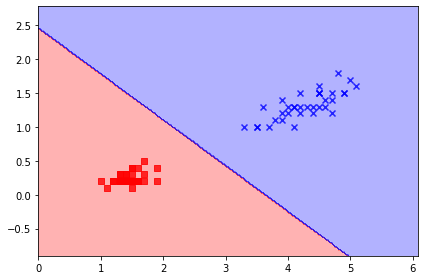

In [41]:
# Applying our logistic regression
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05,
                            n_iter=1000,
                            random_state=1)
lrgd.fit(X_train_01_subset,
        y_train_01_subset)

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt 
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl)
    
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='black', facecolors='none',
                    linewidth=1, marker='o', alpha=0.1,
                    s=100, label='test set')

plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)
plt.tight_layout()
plt.show()


# Using scikit-learn instead

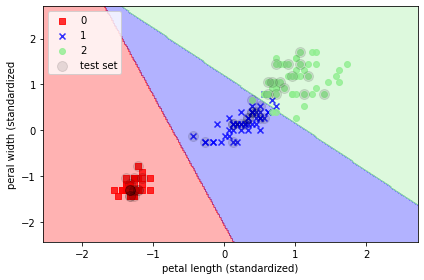

In [42]:
from sklearn.linear_model import LogisticRegression

#using all data
X = iris.data[:, [2, 3]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs',
                        multi_class='ovr') #using one vs all
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                     y_combined,
                     classifier=lr,
                     test_idx=range(105, 150))

plt.xlabel('petal length (standardized)')
plt.ylabel('peral width (standardized')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()